Less aggressive augmentation  
prev model: model_12

In [1]:
import os
import pickle

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import tqdm
from torch.nn import functional as fnn
from torch.utils import data
from torchvision import transforms

from hack_utils import ScaleMinSideToSize, CropCenter, RandomHorizontalFlip, TransformByKeys
from hack_utils import ThousandLandmarksDataset
from hack_utils import restore_landmarks_batch, create_submission
from hack_utils import stqdm
from hack_train import predict

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_DIR = '../data/'
LOCAL_DATA_DIR = '/work/local_data/made_cv/contest1'

In [3]:
GPUs = [0, 1, 2]

In [4]:
NUM_PTS = 971
CROP_SIZE = 128
BATCH_SIZE = 256 * len(GPUs)
LR = 1e-3
NUM_WORKERS = 24
MODEL_NAME = 'model_16'

In [5]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
def train(model, loader, loss_fn, optimizer, device):
    model.train()
    train_loss = []
    for batch in stqdm(loader, total=len(loader), desc="training...", leave=True):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)

        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.mean(train_loss)

In [7]:
def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    for batch in stqdm(loader, total=len(loader), desc="validation...", leave=True):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        val_loss.append(loss.item())

    return np.mean(val_loss)

In [8]:
train_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
#     RandomHorizontalFlip(0.5),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.4782, 0.3758, 0.3277], std=[0.3077, 0.2652, 0.2521]), ("image",)),
    TransformByKeys(transforms.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3)), ("image",)),
])

In [9]:
test_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.4782, 0.3758, 0.3277], std=[0.3077, 0.2652, 0.2521]), ("image",)),
])

In [10]:
train_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'train'), train_transforms, split="train")
val_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'train'), test_transforms, split="val")

Total lines (without header): 393930
Loading train dataset (315144 lines)



Total lines (without header): 393930
Loading val dataset (78786 lines)


In [11]:
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True,
                                   shuffle=True, drop_last=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True,
                                 shuffle=False, drop_last=False)

In [12]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [13]:
model = models.resnet50(pretrained=True)
# model.fc = nn.Sequential(
#     nn.Linear(model.fc.in_features, model.fc.in_features, bias=False),
#     nn.BatchNorm1d(model.fc.in_features),
#     nn.ReLU(),
#     nn.Linear(model.fc.in_features, 2 * NUM_PTS, bias=True),
# )
model.fc = nn.Linear(model.fc.in_features, 2 * NUM_PTS, bias=True)

model = nn.DataParallel(model, device_ids=GPUs)

model.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [14]:
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01, amsgrad=True)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=1)
loss_fn = fnn.mse_loss

In [15]:
N_EPOCHS = 50
best_val_loss = np.inf
for epoch in stqdm(range(N_EPOCHS), total=N_EPOCHS, desc="Epoch"):
    train_loss = train(model, train_dataloader, loss_fn, optimizer, device=device)
    val_loss = validate(model, val_dataloader, loss_fn, device=device)
    lr_scheduler.step(val_loss)
    print("Epoch #{:2}:\ttrain loss: {:.5f}\tval loss: {:.5f}".format(epoch, train_loss, val_loss))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_best.pth"), "wb") as fp:
            torch.save(model.state_dict(), fp)

Epoch # 0:	train loss: 199.21176	val loss: 14.14467


Epoch # 1:	train loss: 7.29055	val loss: 4.98154


Epoch # 2:	train loss: 4.57897	val loss: 3.85371


Epoch # 3:	train loss: 3.82056	val loss: 3.20613


Epoch # 4:	train loss: 3.43657	val loss: 2.94886


Epoch # 5:	train loss: 3.13492	val loss: 2.59673


Epoch # 6:	train loss: 2.86669	val loss: 2.59528


Epoch # 7:	train loss: 2.72932	val loss: 2.51988


Epoch # 8:	train loss: 2.65001	val loss: 2.37075


Epoch # 9:	train loss: 2.50865	val loss: 2.34454


Epoch #10:	train loss: 2.45599	val loss: 2.17552


Epoch #11:	train loss: 2.32352	val loss: 2.09567


Epoch #12:	train loss: 2.27138	val loss: 2.20379


Epoch #13:	train loss: 2.22935	val loss: 2.05693


Epoch #14:	train loss: 2.16357	val loss: 2.01092


Epoch #15:	train loss: 2.08622	val loss: 1.97934


Epoch #16:	train loss: 2.04604	val loss: 1.96782


Epoch #17:	train loss: 2.00093	val loss: 2.12180


Epoch #18:	train loss: 1.95635	val loss: 1.92656


Epoch #19:	train loss: 1.97161	val loss: 1.97155


Epoch #20:	train loss: 1.88363	val loss: 1.93571


Epoch #21:	train loss: 1.70685	val loss: 1.80796


Epoch #22:	train loss: 1.64704	val loss: 1.79347


Epoch #23:	train loss: 1.61961	val loss: 1.84799


Epoch #24:	train loss: 1.59802	val loss: 1.85253


Epoch #25:	train loss: 1.51884	val loss: 1.76260


Epoch #26:	train loss: 1.49004	val loss: 1.75519


Epoch #27:	train loss: 1.46926	val loss: 1.74801


Epoch #28:	train loss: 1.45143	val loss: 1.76448


Epoch #29:	train loss: 1.45447	val loss: 1.75415


Epoch #30:	train loss: 1.41222	val loss: 1.73193


Epoch #31:	train loss: 1.39988	val loss: 1.74104


Epoch #32:	train loss: 1.38963	val loss: 1.73905


Epoch #33:	train loss: 1.37108	val loss: 1.73213


Epoch #34:	train loss: 1.36202	val loss: 1.73707


Epoch #35:	train loss: 1.35191	val loss: 1.72843


Epoch #36:	train loss: 1.35388	val loss: 1.73287


Epoch #37:	train loss: 1.34567	val loss: 1.73318


Epoch #38:	train loss: 1.34109	val loss: 1.73345


Epoch #39:	train loss: 1.34439	val loss: 1.73268


KeyboardInterrupt: 

In [16]:
f'Best validation loss: {best_val_loss}'

'Best validation loss: 1.7284331692075265'

In [17]:
with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_best.pth"), "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

In [18]:
test_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'test'), test_transforms, split="test")
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True,
                                  shuffle=False, drop_last=False)

Total lines (without header): 99819


In [19]:
test_predictions = predict(model, test_dataloader, device)
with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_test_predictions.pkl"), "wb") as fp:
    pickle.dump({"image_names": test_dataset.image_names,
                 "landmarks": test_predictions}, fp)

In [20]:
create_submission(DATA_DIR, test_predictions,
                 os.path.join(DATA_DIR, f"{MODEL_NAME}_submit_val_loss_{best_val_loss:.5f}.csv"))

In [21]:
TEST_PREDICTIONS_FILENAME = os.path.join(DATA_DIR, f"{MODEL_NAME}_test_predictions.pkl")
NUM_IMAGES_TO_SHOW = 16
NUM_COLS = 4
NUM_ROWS = NUM_IMAGES_TO_SHOW // NUM_COLS + int(NUM_IMAGES_TO_SHOW % NUM_COLS != 0)

In [22]:
def draw_landmarks(image, landmarks):
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)
    return image

In [23]:
with open(TEST_PREDICTIONS_FILENAME, "rb") as fp:
    results = pickle.load(fp)
image_names = results["image_names"]
landmarks = results["landmarks"]

print("Images:", len(image_names))
print("Landmarks shape:", landmarks.shape)

if len(image_names) < NUM_IMAGES_TO_SHOW:
    raise RuntimeError(f"Choose less images to show, you have only {len(image_names)}")

Images: 99819
Landmarks shape: (99819, 971, 2)


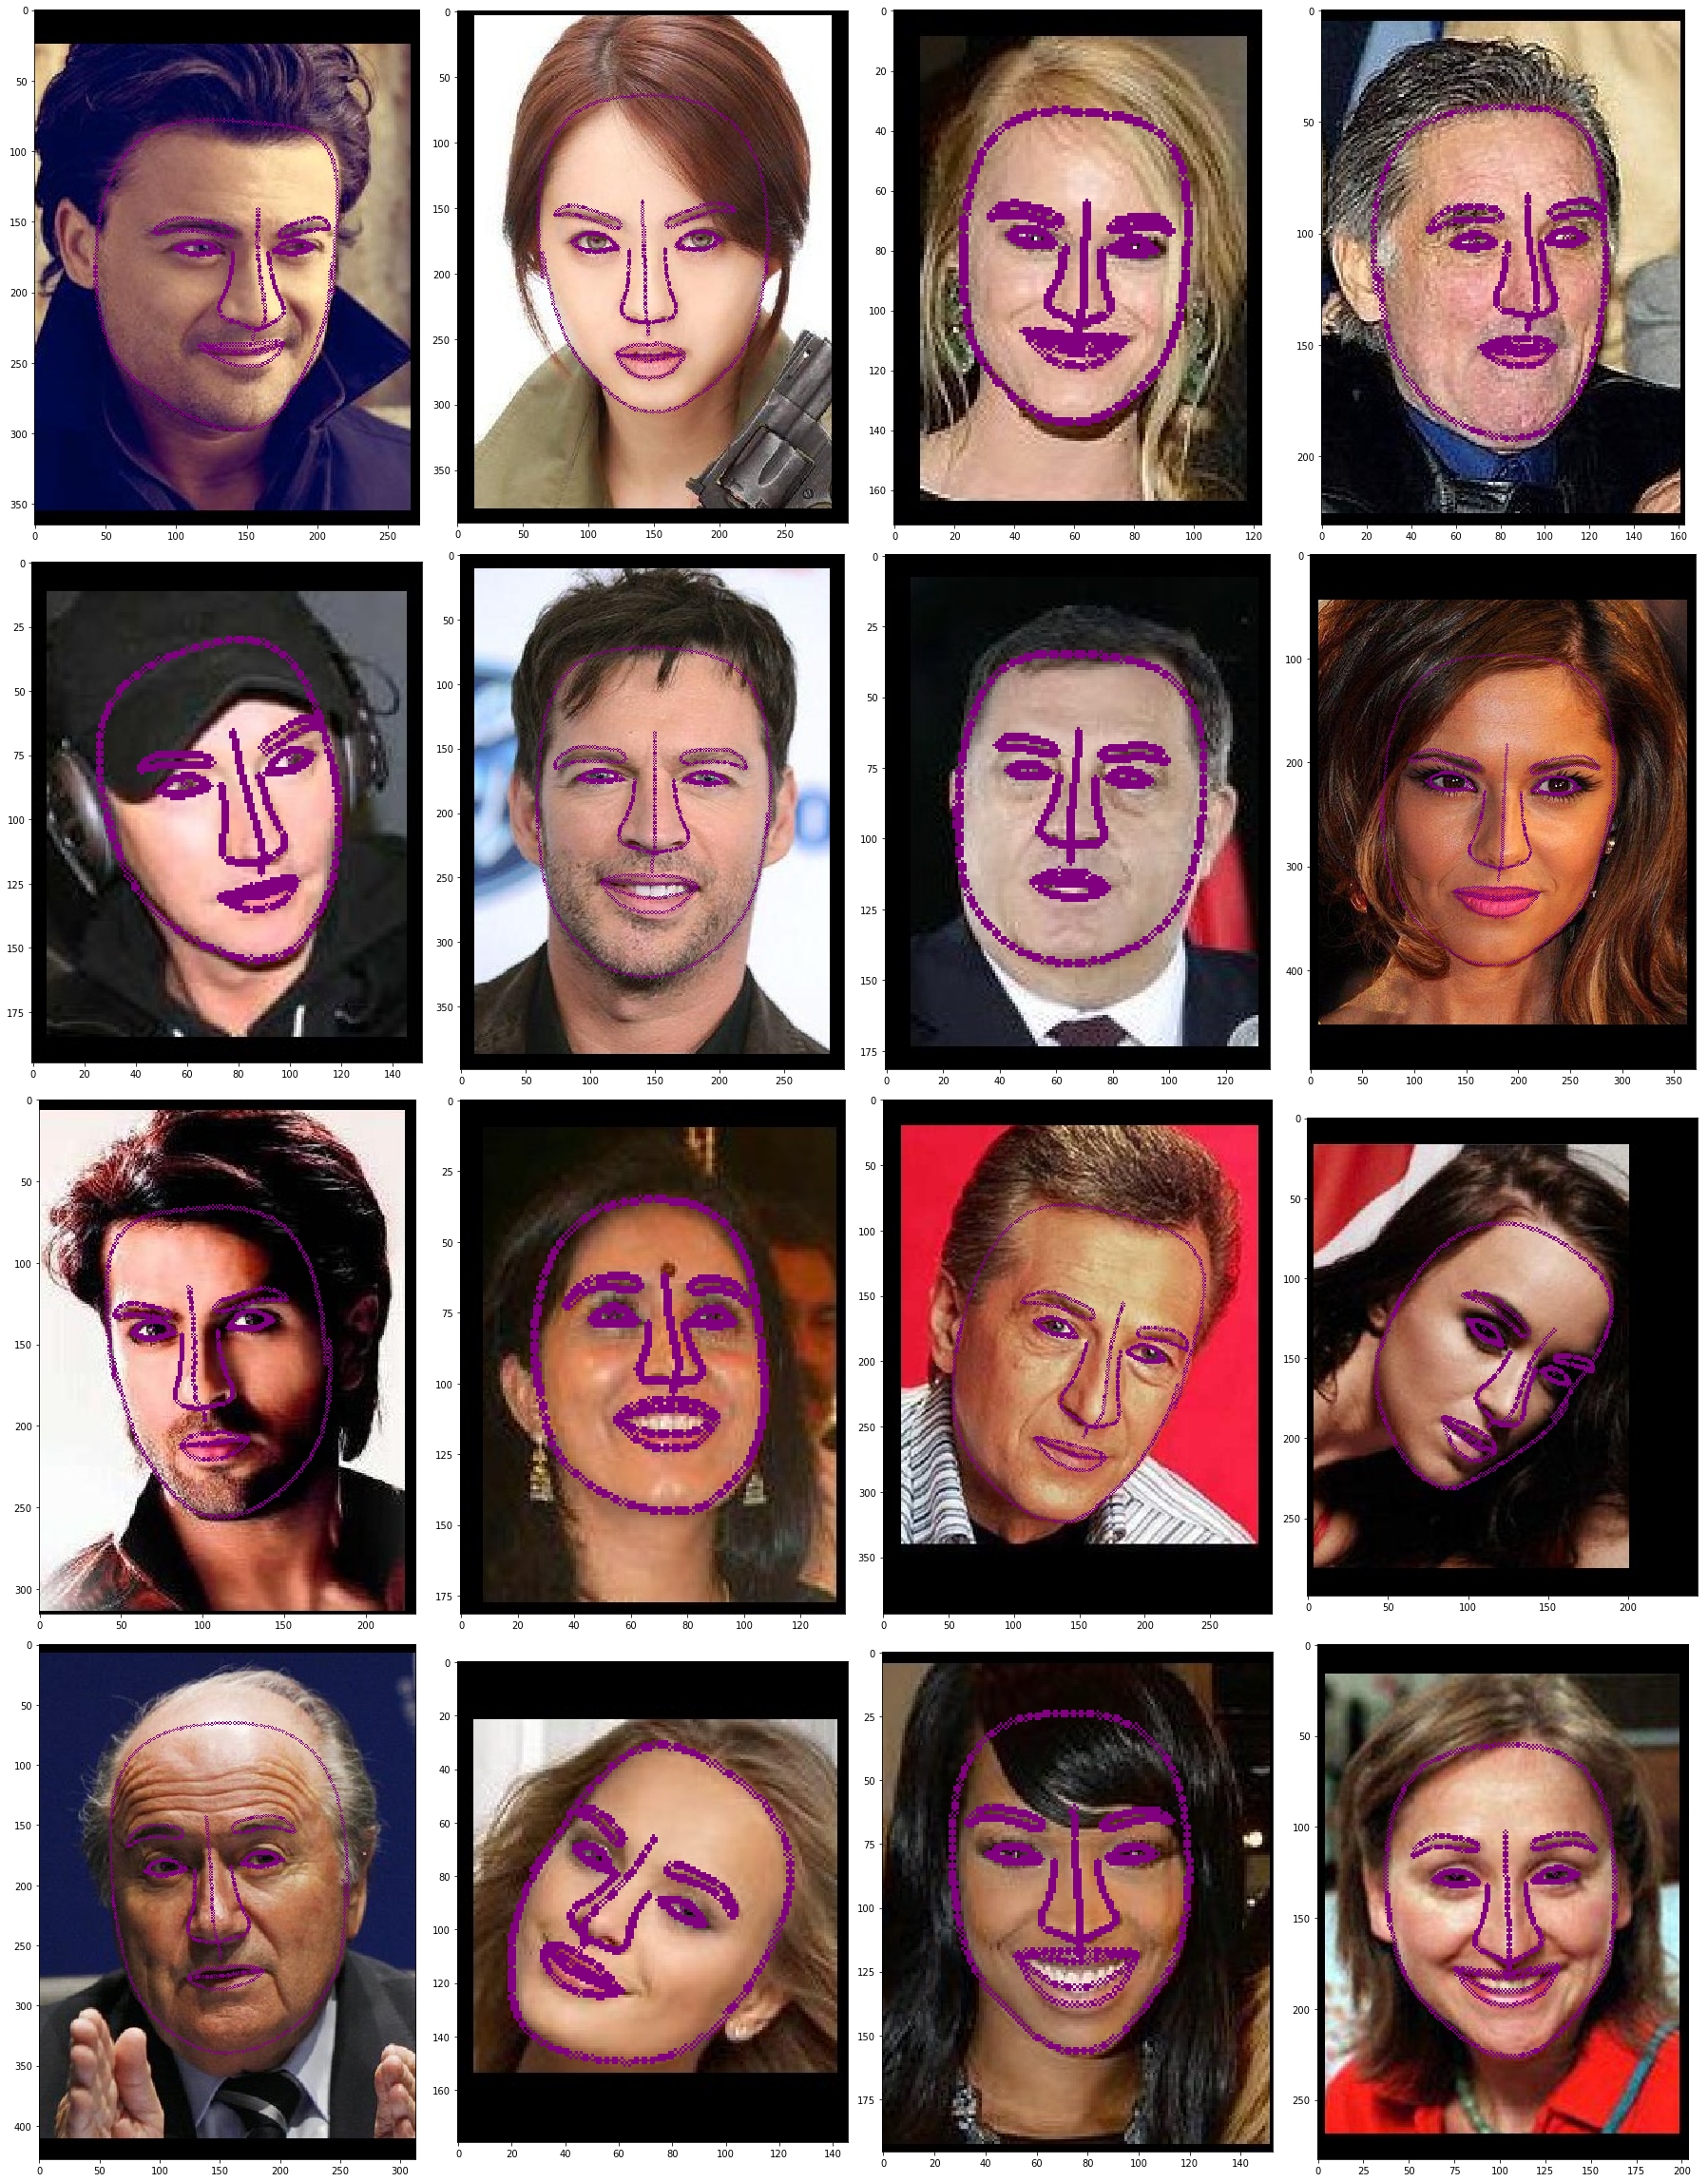

In [24]:
random_idxs = np.random.choice(len(image_names), size=min(NUM_IMAGES_TO_SHOW, len(image_names)), replace=False)

plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(random_idxs, 1):
    image = cv2.imread(image_names[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = draw_landmarks(image, landmarks[idx])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image)

plt.tight_layout()
plt.show()